In [1]:
using DifferentialEquations , StochasticDiffEq, DiffEqJump, Plots

In [2]:
struct AffectIndex{F1, F2}
  affect_index!::F1
  index::F2
end
function (p::AffectIndex)(integrator)
    return p.affect_index!(integrator, p.index)
end

####

In [3]:
function f(du,u,p,t)
  du[1] = u[1]
end
function g(du,u,p,t)
  du[1] = u[1]
end
iv = [0.2]
prob = SDEProblem(f,g,iv,(0.0,10.0))

rate(u,p,t) = 2
affect_index!(integrator, index) = (integrator.u[index] = integrator.u[index]/2 )
#(integrator.u[index] = integrator.u[index]/2)
jumps = [ConstantRateJump(rate,AffectIndex(affect_index!, 1)) for i in 1:2 ]
jump_prob = JumpProblem(prob,Direct(),JumpSet((), jumps, nothing, nothing))

JumpProblem with problem SDEProblem and aggregator Direct
Number of constant rate jumps: 2
Number of variable rate jumps: 0


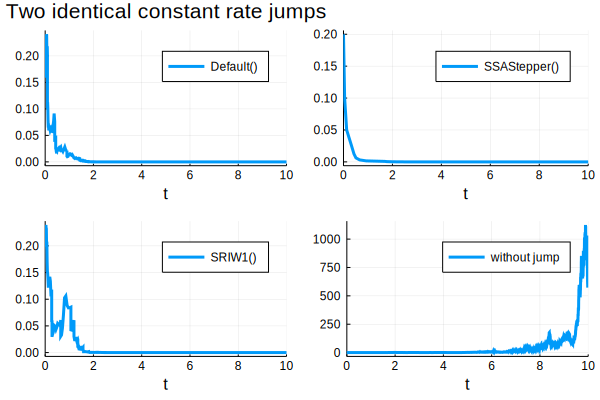

In [4]:
#comapring different methods of solving
sol_o = solve(jump_prob)
p1 = plot(sol_o, label = "Default()", title= "Two identical constant rate jumps")

sol_ssas = solve(jump_prob, SSAStepper())
p2 = plot(sol_ssas, label = "SSAStepper()")


sol_sriw1 = solve(jump_prob, SRIW1())
p3 = plot(sol_sriw1, label = "SRIW1()")


sol_without_jump_o = solve(prob)
p4 = plot(sol_without_jump_o,  label = "without jump")

plot(p1, p2, p3, p4, layout = (2, 2), legend = true )

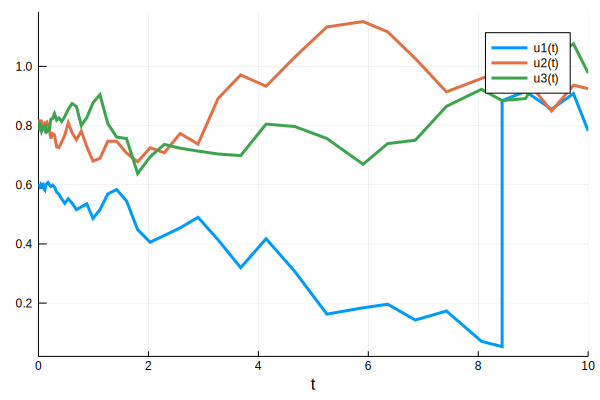

In [5]:
#implementing model of firms adapting new innovations
function μ_SDE(du,u,p,t)
  du .= p.μ
end

function σ_SDE(du,u,p,t)
  du .= p.σ
end

p = (μ = 0.01, σ = 0.1, N = 3) # if all constant
T = 10.0  # maximum time length
x_iv = rand(p.N)  # just draws from the inital condition

prob = SDEProblem(μ_SDE, σ_SDE, x_iv ,(0.0, T), p)
rate(u,p,t) = 0.2
affect_index!(integrator, index) = (integrator.u[index] = max(integrator.u[index], integrator.u[rand(1:integrator.p.N)]) )
#(integrator.u[index] = integrator.u[index]/2)
jumps = [ConstantRateJump(rate,AffectIndex(affect_index!, i)) for i in 1:p.N]
jump_list = JumpSet((), jumps, nothing, nothing)
jump_prob = JumpProblem(prob,Direct(),jump_list)
sol_sriw1 = solve(jump_prob, SRIW1())
plot(sol_sriw1)